In [19]:
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pyranges as pr

## Read in ref and non-ref insertions

In [20]:
# read the rmsk file
rmsk = pd.read_csv(
    # snakemake.input.rmsk[0],
     "/raidixshare_logg01/mcuoco/internal/BSMN/resources/hs38DH/hs38DH.fa.out",
    skiprows=3,
    delim_whitespace=True,
    names=["Chromosome", "Start", "End", "Strand", "repeat"],
    usecols=[4, 5, 6, 8, 9],
)
# filter for rep_names
rep_names = [
    "L1HS_3end",
    "L1PA2_3end",
    "L1PA3_3end",
    "L1PA4_3end",
    "L1PA5_3end",
    "L1PA6_3end",
]
rmsk = rmsk[rmsk["repeat"].isin(rep_names)]
rmsk["Strand"] = rmsk.apply(lambda x: "+" if x.Strand == "+" else "-", axis=1)
rmsk = pr.PyRanges(rmsk)

In [21]:
knrgl = pd.read_csv(
    # snakemake.input.knrgl[0],
    "/raidixshare_logg01/mcuoco/internal/BSMN/resources/LIBD74/hs38DH_insertions.bed",
    sep="\t",
    header=None,
    names=["Chromosome", "Start", "End", "Strand", "SVLEN", "SVTYPE"],
    dtype={"Chromosome": str, "Start": int, "End": int},
)
knrgl["Start"] = knrgl.apply(
    lambda x: x.Start - 750 if x.Strand == "-" else x.Start, axis=1
)
knrgl["End"] = knrgl.apply(lambda x: x.End + 750 if x.Strand == "+" else x.End, axis=1)
knrgl = pr.PyRanges(knrgl)

## Find peaks

Strategy 3 (inspired by MACS):

1. Filter for high-quality read1
2. Create background distribution by sliding 1k, 5k, and 10k bp windows across the genome
3. Test 300 bp windows for enrichment against max background using poisson test

In [22]:
# fn = "/home/mcuoco/workflows/sz_slavseq/results/align/tags/hs38DH/LIBD74/bulk/gDNA_usd2.bam"
fn = "/home/mcuoco/workflows/sz_slavseq/results/align/tags/hs38DH/LIBD74/mda/usd02_A2_S128.bam"

In [18]:
# Filter for reads of interest
with pysam.AlignmentFile(fn, "rb") as inbam:
	with pysam.AlignmentFile("out.bam", "wb", template=inbam) as outbam:
		for r in inbam.fetch():
			if (r.is_read1
				and (not r.is_unmapped)
				and (not r.is_secondary)
				and (not r.is_supplementary)
				and (not r.has_tag("XA")) 	
				and (not r.has_tag("SA"))
				and (r.has_tag("YA") and r.has_tag("YG"))
				and (r.get_tag("YA") > 20 and r.get_tag("YA") > r.get_tag("YG"))
				and (r.mapping_quality >= 60)
				):
				outbam.write(r)
pysam.index("out.bam")

''

In [48]:
from scipy.stats import poisson
from collections import deque

class PeakCaller:
	def __init__(self, bam: pysam.AlignmentFile, peak_size: int, bg_sizes: list) -> None:
		"""
		Initializes a PeakCaller object with a bam file and peak and background window sizes.
		input:
		:param bam: pysam.AlignmentFile, opened bam file
		:param peak_size: int, size of peak
		:param bg_sizes: list, sizes of background windows
		NOTE: Slow with high numbers of bg_sizes, since each size requires bam file to be opened.
		"""
		self.bam = bam
		assert peak_size < min(bg_sizes), "peak size must be smaller than background window sizes"
		self.peak_size = peak_size
		self.bg_sizes = bg_sizes

	def window(self, contig, window_size: int):
		"""
		Generator that yields windows of reads from a bam file.
		"""

		f = self.bam.fetch(contig = contig, multiple_iterators=True) # get generator of contig reads in file
		reads = deque() # initialize deque of reads

		# get first read
		try:
			r = next(f) 
		except StopIteration:
			return
		
		for start in range(0, self.bam.get_reference_length(contig) - window_size + 1):
			end = start + window_size
			# check if reads need to be removed
			# reads is False if reads is empty
			while reads and reads[0].reference_start < start:
				reads.popleft()
			
			# check if reads need to be added
			while (r.reference_start < end) and (r.reference_start >= start):
				reads.append(r)
				try:
					r = next(f)
				except StopIteration:
					if reads:
						return {"chr": contig, "start": start, "center": int(start + window_size/2), "end": end, "count": len(reads)}
					else:
						return

			# yield the window
			if reads:
				yield {"chr": contig, "start": start, "center": int(start + window_size/2), "end": end, "count": len(reads)}

	def find_peaks(self, pval_cutoff=10e-5):
		"""
		Generator that yields peaks from a bam file. 
		"""
		for contig in self.bam.references:
		# for contig in self.bam.references[24:]: # for testing small contigs
		# for contig in ["chr21","chr22"]: # for testing small chromosomes
			
			# get window generators
			bg_windows = {ws: self.window(contig,ws) for ws in self.bg_sizes}

			# initialize first background windows
			bg = {} 
			for ws, w in bg_windows.items():
				try:
					bg[ws] = next(w)
				except StopIteration:
					break

			# if no background windows, skip contig
			if not bg:
				continue

			for p in self.window(contig, self.peak_size): 
				# adjust window centers over peak center
				# for each window_size, move to next window if:
				# 1) peak center is greater than window center 
				for ws in bg.keys():
					while p["center"] > bg[ws]["center"]:
						try:
							bg[ws] = next(bg_windows[ws])
						except StopIteration:
							break

				# test peak against window with largest lambda
				# get biggest lambda value for each window_size
				p["windows"] = bg.copy()
				p["lambda"] = max([int(round((w["count"]/(w["end"] - w["start"]))*self.peak_size)) for w in bg.values()])
				
				# calculate p-value
				p["p"] = poisson.pmf(p["count"], p["lambda"])

				# yield peak
				if p["p"] < pval_cutoff:
					yield p

	def merge_peaks(self):
		"""
		Merge overlapping peaks
		"""
		peaks = self.find_peaks()
		p = next(peaks)
		while True:
			# if next peak overlaps with current peak, extend current peak,
			# else, yield current peak and set next peak as current peak
			try:
				n = next(peaks)
				if n["chr"] == p["chr"] and n["start"] <= p["end"]:
					p["end"] = n["end"]
				else:
					p["reads"] = list(self.bam.fetch(p["chr"], p["start"], p["end"]))
					p["count"] = len(p["reads"])
					yield p
					p = n
			# if no more peaks, yield current peak
			except StopIteration:
				p["reads"] = list(self.bam.fetch(p["chr"], p["start"], p["end"]))
				p["count"] = len(p["reads"])
				return p

	def run_peak_caller(self):
		"""
		Runs peak caller and returns peaks as a pandas DataFrame.
		"""
		peaks = []
		for p in self.merge_peaks():
			del p["windows"]
			peaks.append(p)
		return pd.DataFrame(peaks)


In [49]:
import cProfile, pstats

with pysam.AlignmentFile("out.bam", "rb") as bam:
	pc = PeakCaller(bam, 300, [1000, 5000, 10000])
	peaks = pc.run_peak_caller()
	# peaks = cProfile.run('pc.run_peak_caller()', 'restats')
	# p = pstats.Stats('restats')
	# p.sort_stats('tottime').print_stats(20)


[None]

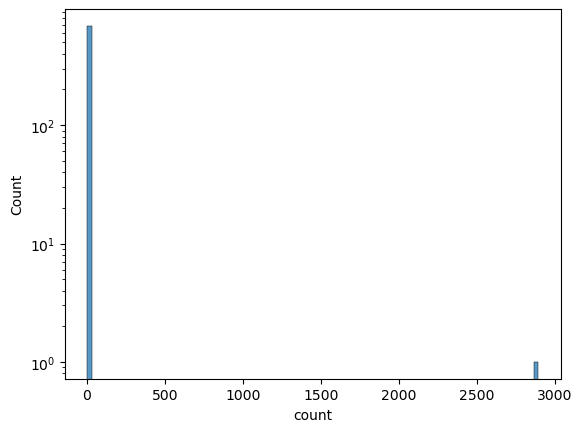

In [8]:
fig = sns.histplot(peaks["count"], bins = 100)
fig.set(yscale="log")

Found 689 peaks


[None]

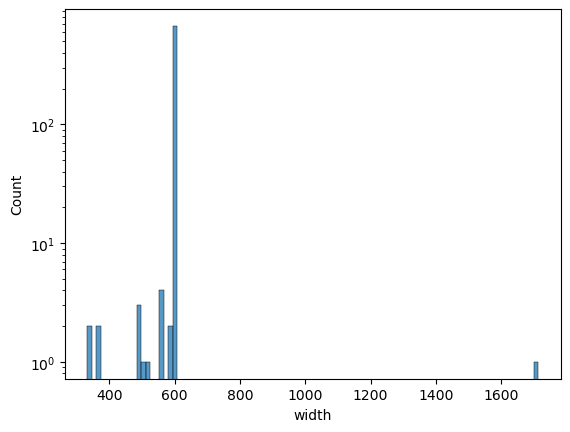

In [9]:
print(f"Found {len(peaks)} peaks")
peaks["width"] = peaks["end"] - peaks["start"]
fig = sns.histplot(peaks["width"], bins=100)
fig.set(yscale="log")

In [247]:
def label_peaks(df):

	df = pr.PyRanges(df)

	# add rmsk and knrgl labels
	df_rmsk = df.overlap(rmsk).df.set_index(["Chromosome", "Start", "End"])
	df_knrgl = df.overlap(knrgl).df.set_index(["Chromosome", "Start", "End"])
	rmsk_covered = len(rmsk.overlap(df))
	knrgl_covered = len(knrgl.overlap(df))

	df = df.df.set_index(["Chromosome", "Start", "End"])
	df["rmsk"] = df.index.isin(df_rmsk.index)
	df["knrgl"] = df.index.isin(df_knrgl.index)
	df["label"] = df.apply(lambda x: "knrgl" if x.knrgl else "rmsk" if x.rmsk else "other", axis=1)

	knrgl_peaks = sum(df["label"] == "knrgl")
	rmsk_peaks = sum(df["label"] == "rmsk")
	
	print(f"{rmsk_peaks} peaks covering {rmsk_covered}/{len(rmsk)} rmsk L1 annotations")
	print(f"{knrgl_peaks} peaks covering {knrgl_covered}/{len(knrgl)} knrgl L1 annotations")

	# plot
	fig = sns.JointGrid(data=df.reset_index(), x="width", y="nreads", hue="label", marginal_ticks=True, hue_order=["other","rmsk","knrgl"])
	fig.plot_joint(sns.scatterplot, alpha = 0.5)
	fig.ax_joint.set(yscale = "log")

	fig.plot_marginals(sns.histplot, bins=100, element="step", fill=False)
	fig.ax_marg_x.set(yscale = "log")
	fig.ax_marg_y.set(xscale = "log")
	fig.ax_joint.set(xlabel = "Peak width (bp)", ylabel = "Number of reads")
	plt.show()

	return df

87 peaks covering 103/264879 rmsk L1 annotations
1 peaks covering 1/267 knrgl L1 annotations


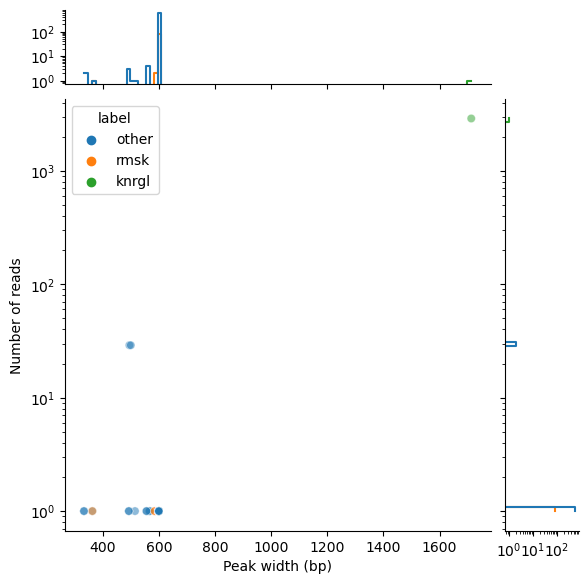

center  nreads  lambda             p  \
Chromosome Start    End                                                  
chr22      10714909 10715508  10715059.0       1       0  0.000000e+00   
           10780811 10781377  10780961.0       1       0  0.000000e+00   
           10781461 10782027  10781611.0       1       0  0.000000e+00   
           10937026 10937625  10937176.0       1       0  0.000000e+00   
           11293950 11294549  11294100.0       1       0  0.000000e+00   
...                                  ...     ...     ...           ...   
           50403710 50404309  50403860.0       1       0  0.000000e+00   
           50448751 50449350  50448901.0       1       0  0.000000e+00   
           50452794 50453393  50452944.0       1       0  0.000000e+00   
           50617866 50618465  50618016.0       1       0  0.000000e+00   
           50669333 50669932  50669483.0       1     146  5.719506e-62   

                                                                          reads  \
Chromosome Start    End                                                           
chr22      10714909 10715508  [A00280:91:HHKN3DRXX:2:2202:27968:7748\t99\t#2...   
           10780811 10781377  [A00280:91:HHKN3DRXX:2:2166:31702:24361\t97\t#...   
           10781461 10782027  [A00280:124:HL2L5DRXX:1:2238:13015:21308\t113\...   
           10937026 10937625  [A00280:91:HHKN3DRXX:2:2155:5439:12477\t97\t#2...   
           11293950 11294549  [A00280:91:HHKN3DRXX:2:2207:29215:30890\t81\t#...   
...                                                                         ...   
           50403710 50404309  [A00280:91:HHKN3DRXX:1:2241:8684:31093\t97\t#2...   
           50448751 50449350  [A00280:91:HHKN3DRXX:1:2108:14226:18427\t83\t#...   
           50452794 50453393  [A00280:91:HHKN3DRXX:1:2159:29026:34538\t113\t...   
           50617866 50618465  [A00280:124:HL2L5DRXX:1:2168:16161:4899\t99\t#...   
           50669333 50669932  [A00280:91:HHKN3DRXX:2:2127:6470:2362\t83\t#21...   

                              width   rmsk  knrgl  label  
Chromosome Start    End                                   
chr22      10714909 10715508    599  False  False  other  
           10780811 10781377    566  False  False  other  
           10781461 10782027    566  False  False  other  
           10937026 10937625    599  False  False  other  
           11293950 11294549    599   True  False   rmsk  
...                             ...    ...    ...    ...  
           50403710 50404309    599  False  False  other  
           50448751 50449350    599  False  False  other  
           50452794 50453393    599  False  False  other  
           50617866 50618465    599  False  False  other  
           50669333 50669932    599  False  False  other  

[689 rows x 9 columns]

In [248]:
peaks.rename(columns={"chr": "Chromosome", "start": "Start", "end": "End", "count": "nreads"}, inplace=True)
label_peaks(peaks)